In [31]:
import itertools
from keybert import KeyBERT
from tqdm import tqdm
import os

## Parameters of Grid search

In [24]:
# Parameter grids
ngram_ranges = [(1,1), (1,2), (2,2)]
nr_candidates_list = [18, 19, 20, 21]
diversity_params = [0.4, 0.5, 0.6]
N = 5  # Number of keywords to extract

In [25]:
# Load spaCy
import spacy
nlp = spacy.load("en_core_web_sm")

## Evaluation and keybert functions

In [26]:
# Evaluation function: counts both exact and partial matches
def evaluate_results(results_post, gold_keywords):
    precisions, recalls, f1s = [], [], []
    for pred, gold in zip(results_post, gold_keywords):
        pred_set = set(pred)
        gold_set = set(gold)
        exact_matches = set([p for p in pred_set if p in gold_set])
        partial_matches = set([
            p for p in pred_set
            if any((p in g or g in p) for g in gold_set) and p not in exact_matches
        ])
        total_matches = len(exact_matches) + len(partial_matches)
        precision = total_matches / len(pred) if pred else 0
        recall = total_matches / len(gold) if gold else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)
    return avg_precision, avg_recall, avg_f1

In [27]:
def run_experiment(docs, gold_keywords, use_mmr=False, use_maxsum=False):
    results_summary = []
    best_f1 = 0
    best_params = None

    for ngram_range, nr_candidates in itertools.product(ngram_ranges, nr_candidates_list):
        if use_mmr:
            for diversity in diversity_params:
                kw_model = KeyBERT()
                results_post = []
                for doc in tqdm(docs, desc=f"MMR ngram={ngram_range} nc={nr_candidates} div={diversity}"):
                    kws_post = kw_model.extract_keywords(
                        doc, top_n=N,
                        keyphrase_ngram_range=ngram_range,
                        use_mmr=True,
                        diversity=diversity,
                        nr_candidates=nr_candidates
                    )
                    kws_post = [kw for kw, _ in kws_post]
                    results_post.append(kws_post)
                precision, recall, f1 = evaluate_results(results_post, gold_keywords)
                results_summary.append({
                    "method": "MMR",
                    "ngram_range": ngram_range,
                    "nr_candidates": nr_candidates,
                    "diversity": diversity,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1
                })
                print(f"MMR ngram={ngram_range} nr_candidates={nr_candidates} diversity={diversity} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = ("MMR", ngram_range, nr_candidates, diversity)
        elif use_maxsum:
            kw_model = KeyBERT()
            results_post = []
            for doc in tqdm(docs, desc=f"MaxSum ngram={ngram_range} nc={nr_candidates}"):
                kws_post = kw_model.extract_keywords(
                    doc, top_n=N,
                    keyphrase_ngram_range=ngram_range,
                    use_maxsum=True,
                    nr_candidates=nr_candidates
                )
                kws_post = [kw for kw, _ in kws_post]
                results_post.append(kws_post)
            precision, recall, f1 = evaluate_results(results_post, gold_keywords)
            results_summary.append({
                "method": "MaxSum",
                "ngram_range": ngram_range,
                "nr_candidates": nr_candidates,
                "diversity": None,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })
            print(f"MaxSum ngram={ngram_range} nr_candidates={nr_candidates} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")
            if f1 > best_f1:
                best_f1 = f1
                best_params = ("MaxSum", ngram_range, nr_candidates)
    print(f"\nBest: {best_params} | F1={best_f1:.3f}")
    return results_summary, best_f1, best_params

## 500N dataset

In [28]:
import os

# read docs and gold keywords   

docs_dir = os.path.join("500N-KPCrowd-v1.1", "500N-KPCrowd-v1.1/docsutf8")
keys_dir = os.path.join("500N-KPCrowd-v1.1", "500N-KPCrowd-v1.1/keys")
doc_files = sorted(os.listdir(docs_dir))
key_files = sorted(os.listdir(keys_dir))
docs = []
gold_keywords = [] 
for doc_file, key_file in zip(doc_files, key_files):
    with open(os.path.join(docs_dir, doc_file), encoding='utf-8') as f:
        docs.append(f.read())
    with open(os.path.join(keys_dir, key_file), encoding='utf-8') as f:
        gold_keywords.append([line.strip().lower() for line in f if line.strip()])

In [29]:
# Run MMR tuning
results500N_summary_mmr, best500N_f1_mmr, best500N_params_mmr = run_experiment(docs=docs, gold_keywords=gold_keywords, use_mmr=True)

MMR ngram=(1, 1) nc=18 div=0.4: 100%|██████████| 500/500 [01:55<00:00,  4.31it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.4 | Precision=0.728 | Recall=0.095 | F1=0.163


MMR ngram=(1, 1) nc=18 div=0.5: 100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.5 | Precision=0.712 | Recall=0.093 | F1=0.159


MMR ngram=(1, 1) nc=18 div=0.6: 100%|██████████| 500/500 [01:08<00:00,  7.31it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.6 | Precision=0.686 | Recall=0.090 | F1=0.153


MMR ngram=(1, 1) nc=19 div=0.4: 100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.4 | Precision=0.728 | Recall=0.095 | F1=0.163


MMR ngram=(1, 1) nc=19 div=0.5: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.5 | Precision=0.712 | Recall=0.093 | F1=0.159


MMR ngram=(1, 1) nc=19 div=0.6: 100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.6 | Precision=0.686 | Recall=0.090 | F1=0.153


MMR ngram=(1, 1) nc=20 div=0.4: 100%|██████████| 500/500 [01:20<00:00,  6.23it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.4 | Precision=0.728 | Recall=0.095 | F1=0.163


MMR ngram=(1, 1) nc=20 div=0.5: 100%|██████████| 500/500 [01:04<00:00,  7.77it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.5 | Precision=0.712 | Recall=0.093 | F1=0.159


MMR ngram=(1, 1) nc=20 div=0.6: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.6 | Precision=0.686 | Recall=0.090 | F1=0.153


MMR ngram=(1, 1) nc=21 div=0.4: 100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.4 | Precision=0.728 | Recall=0.095 | F1=0.163


MMR ngram=(1, 1) nc=21 div=0.5: 100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.5 | Precision=0.712 | Recall=0.093 | F1=0.159


MMR ngram=(1, 1) nc=21 div=0.6: 100%|██████████| 500/500 [02:22<00:00,  3.50it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.6 | Precision=0.686 | Recall=0.090 | F1=0.153


MMR ngram=(1, 2) nc=18 div=0.4: 100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.4 | Precision=0.750 | Recall=0.097 | F1=0.165


MMR ngram=(1, 2) nc=18 div=0.5: 100%|██████████| 500/500 [01:53<00:00,  4.40it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.5 | Precision=0.721 | Recall=0.092 | F1=0.158


MMR ngram=(1, 2) nc=18 div=0.6: 100%|██████████| 500/500 [02:36<00:00,  3.20it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.6 | Precision=0.690 | Recall=0.089 | F1=0.153


MMR ngram=(1, 2) nc=19 div=0.4: 100%|██████████| 500/500 [05:20<00:00,  1.56it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.4 | Precision=0.750 | Recall=0.097 | F1=0.165


MMR ngram=(1, 2) nc=19 div=0.5: 100%|██████████| 500/500 [03:18<00:00,  2.51it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.5 | Precision=0.721 | Recall=0.092 | F1=0.158


MMR ngram=(1, 2) nc=19 div=0.6: 100%|██████████| 500/500 [01:56<00:00,  4.31it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.6 | Precision=0.690 | Recall=0.089 | F1=0.153


MMR ngram=(1, 2) nc=20 div=0.4: 100%|██████████| 500/500 [01:58<00:00,  4.23it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.4 | Precision=0.750 | Recall=0.097 | F1=0.165


MMR ngram=(1, 2) nc=20 div=0.5: 100%|██████████| 500/500 [01:51<00:00,  4.49it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.5 | Precision=0.721 | Recall=0.092 | F1=0.158


MMR ngram=(1, 2) nc=20 div=0.6: 100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.6 | Precision=0.690 | Recall=0.089 | F1=0.153


MMR ngram=(1, 2) nc=21 div=0.4: 100%|██████████| 500/500 [01:52<00:00,  4.45it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.4 | Precision=0.750 | Recall=0.097 | F1=0.165


MMR ngram=(1, 2) nc=21 div=0.5: 100%|██████████| 500/500 [01:48<00:00,  4.60it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.5 | Precision=0.721 | Recall=0.092 | F1=0.158


MMR ngram=(1, 2) nc=21 div=0.6: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.6 | Precision=0.690 | Recall=0.089 | F1=0.153


MMR ngram=(2, 2) nc=18 div=0.4: 100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.4 | Precision=0.746 | Recall=0.094 | F1=0.161


MMR ngram=(2, 2) nc=18 div=0.5: 100%|██████████| 500/500 [01:23<00:00,  6.00it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.5 | Precision=0.716 | Recall=0.090 | F1=0.154


MMR ngram=(2, 2) nc=18 div=0.6: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.6 | Precision=0.691 | Recall=0.087 | F1=0.149


MMR ngram=(2, 2) nc=19 div=0.4: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.4 | Precision=0.746 | Recall=0.094 | F1=0.161


MMR ngram=(2, 2) nc=19 div=0.5: 100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.5 | Precision=0.716 | Recall=0.090 | F1=0.154


MMR ngram=(2, 2) nc=19 div=0.6: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.6 | Precision=0.691 | Recall=0.087 | F1=0.149


MMR ngram=(2, 2) nc=20 div=0.4: 100%|██████████| 500/500 [01:12<00:00,  6.85it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.4 | Precision=0.746 | Recall=0.094 | F1=0.161


MMR ngram=(2, 2) nc=20 div=0.5: 100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.5 | Precision=0.716 | Recall=0.090 | F1=0.154


MMR ngram=(2, 2) nc=20 div=0.6: 100%|██████████| 500/500 [01:51<00:00,  4.46it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.6 | Precision=0.691 | Recall=0.087 | F1=0.149


MMR ngram=(2, 2) nc=21 div=0.4: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s]


MMR ngram=(2, 2) nr_candidates=21 diversity=0.4 | Precision=0.746 | Recall=0.094 | F1=0.161


MMR ngram=(2, 2) nc=21 div=0.5: 100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


MMR ngram=(2, 2) nr_candidates=21 diversity=0.5 | Precision=0.716 | Recall=0.090 | F1=0.154


MMR ngram=(2, 2) nc=21 div=0.6: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]

MMR ngram=(2, 2) nr_candidates=21 diversity=0.6 | Precision=0.691 | Recall=0.087 | F1=0.149

Best: ('MMR', (1, 2), 18, 0.4) | F1=0.165


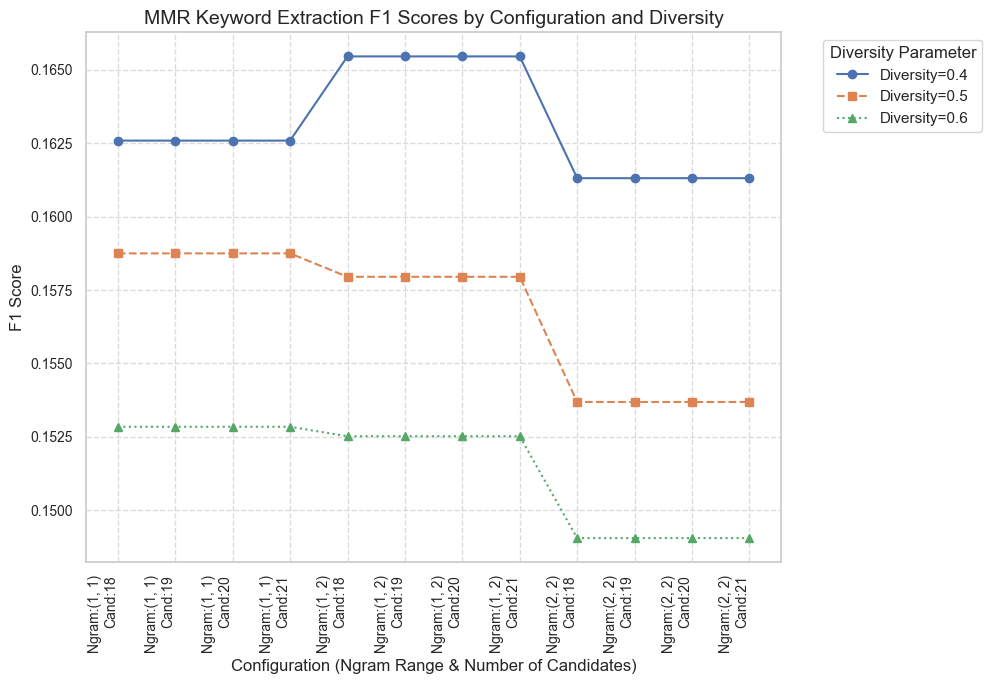

In [62]:
import pandas as pd
import matplotlib.pyplot as plt


# Prepare DataFrame for summary and plotting
df = pd.DataFrame(results500N_summary_mmr) 

plt.figure(figsize=(12, 7)) 

# Define a list of markers and linestyles to cycle through
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))] # Example of custom linestyle

for i, diversity in enumerate(diversity_params):
    subset = df[(df['method'] == 'MMR') & (df['diversity'] == diversity)]
    
    # Sort for cleaner lines 
    subset = subset.sort_values(by=['ngram_range', 'nr_candidates']) 
    
    x_labels = [f"Ngram:{ng}\nCand:{nc}" for ng, nc in zip(subset['ngram_range'], subset['nr_candidates'])]
    
    plt.plot(x_labels, 
             subset['f1'], 
             marker=markers[i % len(markers)], # Cycle through markers
             linestyle=linestyles[i % len(linestyles)], # Cycle through linestyles
             label=f"Diversity={diversity}")

plt.xlabel("Configuration (Ngram Range & Number of Candidates)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("MMR Keyword Extraction F1 Scores by Configuration and Diversity", fontsize=14)
plt.legend(title="Diversity Parameter", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate and align for better visibility
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()


In [41]:
# Run MAXSUM tuning
results500N_summary_maxsum, best500N_f1_maxsum, best500N_params_maxsum = run_experiment(docs=docs, gold_keywords=gold_keywords, use_maxsum=True)

MaxSum ngram=(1, 1) nc=18: 100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


MaxSum ngram=(1, 1) nr_candidates=18 | Precision=0.641 | Recall=0.084 | F1=0.144


MaxSum ngram=(1, 1) nc=19: 100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


MaxSum ngram=(1, 1) nr_candidates=19 | Precision=0.638 | Recall=0.084 | F1=0.144


MaxSum ngram=(1, 1) nc=20: 100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


MaxSum ngram=(1, 1) nr_candidates=20 | Precision=0.629 | Recall=0.084 | F1=0.143


MaxSum ngram=(1, 1) nc=21: 100%|██████████| 500/500 [02:23<00:00,  3.48it/s]


MaxSum ngram=(1, 1) nr_candidates=21 | Precision=0.625 | Recall=0.083 | F1=0.141


MaxSum ngram=(1, 2) nc=18: 100%|██████████| 500/500 [03:47<00:00,  2.20it/s]


MaxSum ngram=(1, 2) nr_candidates=18 | Precision=0.750 | Recall=0.096 | F1=0.165


MaxSum ngram=(1, 2) nc=19: 100%|██████████| 500/500 [02:19<00:00,  3.58it/s]


MaxSum ngram=(1, 2) nr_candidates=19 | Precision=0.744 | Recall=0.095 | F1=0.163


MaxSum ngram=(1, 2) nc=20: 100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


MaxSum ngram=(1, 2) nr_candidates=20 | Precision=0.741 | Recall=0.095 | F1=0.162


MaxSum ngram=(1, 2) nc=21: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


MaxSum ngram=(1, 2) nr_candidates=21 | Precision=0.745 | Recall=0.095 | F1=0.164


MaxSum ngram=(2, 2) nc=18: 100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


MaxSum ngram=(2, 2) nr_candidates=18 | Precision=0.704 | Recall=0.089 | F1=0.153


MaxSum ngram=(2, 2) nc=19: 100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


MaxSum ngram=(2, 2) nr_candidates=19 | Precision=0.702 | Recall=0.089 | F1=0.153


MaxSum ngram=(2, 2) nc=20: 100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


MaxSum ngram=(2, 2) nr_candidates=20 | Precision=0.701 | Recall=0.089 | F1=0.153


MaxSum ngram=(2, 2) nc=21: 100%|██████████| 500/500 [03:01<00:00,  2.75it/s]

MaxSum ngram=(2, 2) nr_candidates=21 | Precision=0.690 | Recall=0.087 | F1=0.149

Best: ('MaxSum', (1, 2), 18) | F1=0.165


   method ngram_range  nr_candidates diversity  precision    recall        f1
0  MaxSum      (1, 1)             18      None     0.6408  0.084477  0.144387
1  MaxSum      (1, 1)             19      None     0.6376  0.084081  0.143685
2  MaxSum      (1, 1)             20      None     0.6292  0.083672  0.142724
3  MaxSum      (1, 1)             21      None     0.6248  0.082743  0.141252
4  MaxSum      (1, 2)             18      None     0.7504  0.096067  0.164674


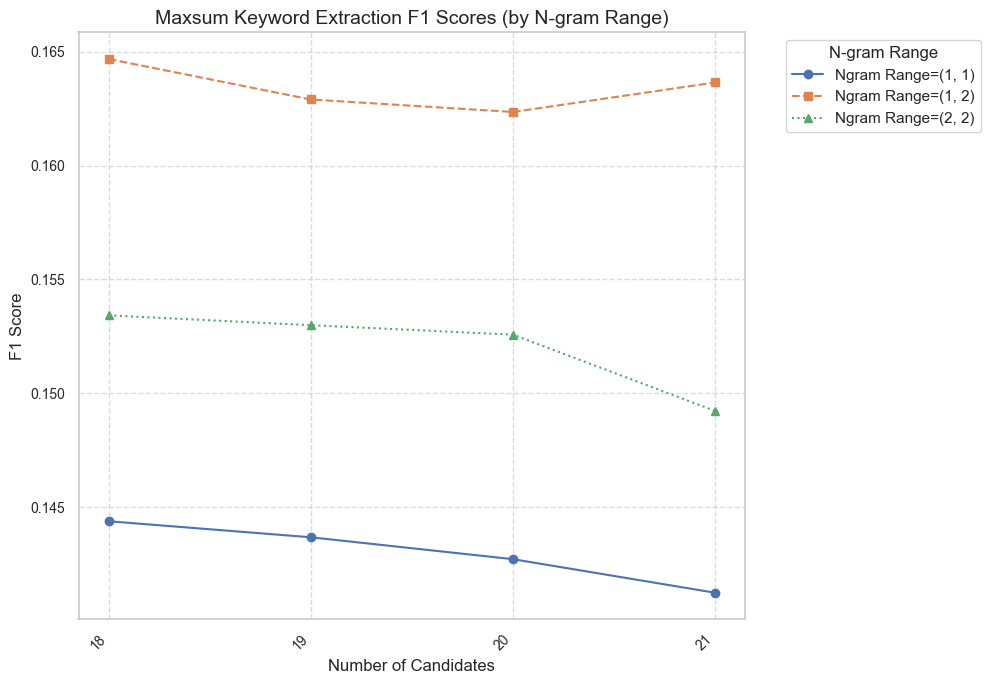

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for summary and plotting 
df = pd.DataFrame(results500N_summary_maxsum)
print(df.head())

# Filter for 'MaxSum' method
maxsum_df = df[df['method'] == 'MaxSum'].copy()

# Convert ngram_range to string for consistent x-axis labels if it's a tuple
maxsum_df['ngram_range_str'] = maxsum_df['ngram_range'].astype(str)

ngram_order = sorted(maxsum_df['ngram_range_str'].unique(),
                     key=lambda x: (int(x.strip('()').split(',')[0]), int(x.strip('()').split(',')[1])))


markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))] 


# --- Plot 1: F1 Score vs. Number of Candidates, with N-gram Range as separate lines ---
plt.figure(figsize=(12, 7)) 

# Get unique ngram_ranges to iterate and plot as separate lines
# Sort them to ensure consistent plotting order
unique_ngram_ranges = sorted(maxsum_df['ngram_range_str'].unique(),
                             key=lambda x: (int(x.strip('()').split(',')[0]), int(x.strip('()').split(',')[1])))

for i, ng_range_str in enumerate(unique_ngram_ranges):
    # Filter for the current ngram_range
    subset = maxsum_df[maxsum_df['ngram_range_str'] == ng_range_str].copy()
    
    # Sort by nr_candidates for a clean line progression
    subset = subset.sort_values(by='nr_candidates')
    
    # Check if subset is not empty to avoid plotting errors
    if not subset.empty:
        plt.plot(subset['nr_candidates'],
                 subset['f1'], # Use 'f1' directly
                 marker=markers[i % len(markers)], # Cycle through markers
                 linestyle=linestyles[i % len(linestyles)], # Cycle through linestyles
                 label=f"Ngram Range={ng_range_str}")

plt.xlabel("Number of Candidates", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Maxsum Keyword Extraction F1 Scores (by N-gram Range)", fontsize=14)
plt.legend(title="N-gram Range", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.xticks(sorted(maxsum_df['nr_candidates'].unique()), rotation=45, ha='right', fontsize=10) # Ensure all candidate values are ticks
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
plt.show()

## SemEval2017 dataset

In [58]:
import os

# read docs and gold keywords   

docs_dir = os.path.join("SemEval2017", "docsutf8")
keys_dir = os.path.join("SemEval2017", "keys")
doc_files = sorted(os.listdir(docs_dir))
key_files = sorted(os.listdir(keys_dir))
docs = []
gold_keywords = [] 
for doc_file, key_file in zip(doc_files, key_files):
    with open(os.path.join(docs_dir, doc_file), encoding='utf-8') as f:
        docs.append(f.read())
    with open(os.path.join(keys_dir, key_file), encoding='utf-8') as f:
        gold_keywords.append([line.strip().lower() for line in f if line.strip()])

In [8]:
docs[3], gold_keywords[3]

('This work shows how our approach based on the combination of Statistical Mechanics and nonlinear PDEs theory provides us with a novel and powerful tool to tackle phase transitions. This method leads to solution of perhaps the most known test-case that exhibits a first order phase transition (semi-heuristically described) such as the van der Waals model. In particular we have obtained the first global mean field partition function (Eq. (9)), for a system of finite number of particles. The partition function is a solution to the Klein–Gordon equation, reproduces the van der Waals isotherms away from the critical region and, in the thermodynamic limit N→∞ automatically encodes the Maxwell equal areas rule. The approach hereby presented is of remarkable simplicity, has been successfully applied to spin\xa0 [17–19,14,16] and macroscopic thermodynamic systems\xa0 [20,15] and can be further extended to include the larger class of models admitting partition functions of the form (4) to be us

In [66]:
# Run MMR tuning
resultsSemEval_summary_mmr, SemEval_best_f1_mmr, SemEval_best_params_mmr = run_experiment(docs=docs, gold_keywords=gold_keywords, use_mmr=True)

MMR ngram=(1, 1) nc=18 div=0.4: 100%|██████████| 493/493 [01:35<00:00,  5.16it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.4 | Precision=0.846 | Recall=0.279 | F1=0.406


MMR ngram=(1, 1) nc=18 div=0.5: 100%|██████████| 493/493 [00:36<00:00, 13.66it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.5 | Precision=0.830 | Recall=0.273 | F1=0.398


MMR ngram=(1, 1) nc=18 div=0.6: 100%|██████████| 493/493 [00:36<00:00, 13.56it/s]


MMR ngram=(1, 1) nr_candidates=18 diversity=0.6 | Precision=0.775 | Recall=0.255 | F1=0.371


MMR ngram=(1, 1) nc=19 div=0.4: 100%|██████████| 493/493 [00:31<00:00, 15.58it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.4 | Precision=0.846 | Recall=0.279 | F1=0.406


MMR ngram=(1, 1) nc=19 div=0.5: 100%|██████████| 493/493 [00:32<00:00, 15.03it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.5 | Precision=0.830 | Recall=0.273 | F1=0.398


MMR ngram=(1, 1) nc=19 div=0.6: 100%|██████████| 493/493 [00:32<00:00, 15.21it/s]


MMR ngram=(1, 1) nr_candidates=19 diversity=0.6 | Precision=0.775 | Recall=0.255 | F1=0.371


MMR ngram=(1, 1) nc=20 div=0.4: 100%|██████████| 493/493 [00:33<00:00, 14.79it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.4 | Precision=0.846 | Recall=0.279 | F1=0.406


MMR ngram=(1, 1) nc=20 div=0.5: 100%|██████████| 493/493 [00:32<00:00, 15.20it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.5 | Precision=0.830 | Recall=0.273 | F1=0.398


MMR ngram=(1, 1) nc=20 div=0.6: 100%|██████████| 493/493 [00:32<00:00, 15.07it/s]


MMR ngram=(1, 1) nr_candidates=20 diversity=0.6 | Precision=0.775 | Recall=0.255 | F1=0.371


MMR ngram=(1, 1) nc=21 div=0.4: 100%|██████████| 493/493 [00:32<00:00, 15.21it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.4 | Precision=0.846 | Recall=0.279 | F1=0.406


MMR ngram=(1, 1) nc=21 div=0.5: 100%|██████████| 493/493 [00:33<00:00, 14.57it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.5 | Precision=0.830 | Recall=0.273 | F1=0.398


MMR ngram=(1, 1) nc=21 div=0.6: 100%|██████████| 493/493 [00:32<00:00, 15.40it/s]


MMR ngram=(1, 1) nr_candidates=21 diversity=0.6 | Precision=0.775 | Recall=0.255 | F1=0.371


MMR ngram=(1, 2) nc=18 div=0.4: 100%|██████████| 493/493 [00:57<00:00,  8.61it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.4 | Precision=0.656 | Recall=0.209 | F1=0.307


MMR ngram=(1, 2) nc=18 div=0.5: 100%|██████████| 493/493 [00:55<00:00,  8.93it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.5 | Precision=0.617 | Recall=0.198 | F1=0.290


MMR ngram=(1, 2) nc=18 div=0.6: 100%|██████████| 493/493 [00:54<00:00,  9.10it/s]


MMR ngram=(1, 2) nr_candidates=18 diversity=0.6 | Precision=0.561 | Recall=0.180 | F1=0.265


MMR ngram=(1, 2) nc=19 div=0.4: 100%|██████████| 493/493 [00:53<00:00,  9.17it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.4 | Precision=0.656 | Recall=0.209 | F1=0.307


MMR ngram=(1, 2) nc=19 div=0.5: 100%|██████████| 493/493 [01:03<00:00,  7.79it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.5 | Precision=0.617 | Recall=0.198 | F1=0.290


MMR ngram=(1, 2) nc=19 div=0.6: 100%|██████████| 493/493 [00:54<00:00,  8.98it/s]


MMR ngram=(1, 2) nr_candidates=19 diversity=0.6 | Precision=0.561 | Recall=0.180 | F1=0.265


MMR ngram=(1, 2) nc=20 div=0.4: 100%|██████████| 493/493 [00:58<00:00,  8.44it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.4 | Precision=0.656 | Recall=0.209 | F1=0.307


MMR ngram=(1, 2) nc=20 div=0.5: 100%|██████████| 493/493 [00:55<00:00,  8.95it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.5 | Precision=0.617 | Recall=0.198 | F1=0.290


MMR ngram=(1, 2) nc=20 div=0.6: 100%|██████████| 493/493 [00:59<00:00,  8.23it/s]


MMR ngram=(1, 2) nr_candidates=20 diversity=0.6 | Precision=0.561 | Recall=0.180 | F1=0.265


MMR ngram=(1, 2) nc=21 div=0.4: 100%|██████████| 493/493 [00:56<00:00,  8.73it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.4 | Precision=0.656 | Recall=0.209 | F1=0.307


MMR ngram=(1, 2) nc=21 div=0.5: 100%|██████████| 493/493 [00:54<00:00,  9.10it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.5 | Precision=0.617 | Recall=0.198 | F1=0.290


MMR ngram=(1, 2) nc=21 div=0.6: 100%|██████████| 493/493 [00:54<00:00,  9.10it/s]


MMR ngram=(1, 2) nr_candidates=21 diversity=0.6 | Precision=0.561 | Recall=0.180 | F1=0.265


MMR ngram=(2, 2) nc=18 div=0.4: 100%|██████████| 493/493 [00:53<00:00,  9.20it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.4 | Precision=0.652 | Recall=0.208 | F1=0.305


MMR ngram=(2, 2) nc=18 div=0.5: 100%|██████████| 493/493 [00:38<00:00, 12.71it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.5 | Precision=0.611 | Recall=0.195 | F1=0.287


MMR ngram=(2, 2) nc=18 div=0.6: 100%|██████████| 493/493 [00:38<00:00, 12.71it/s]


MMR ngram=(2, 2) nr_candidates=18 diversity=0.6 | Precision=0.553 | Recall=0.177 | F1=0.260


MMR ngram=(2, 2) nc=19 div=0.4: 100%|██████████| 493/493 [00:41<00:00, 11.74it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.4 | Precision=0.652 | Recall=0.208 | F1=0.305


MMR ngram=(2, 2) nc=19 div=0.5: 100%|██████████| 493/493 [00:38<00:00, 12.96it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.5 | Precision=0.611 | Recall=0.195 | F1=0.287


MMR ngram=(2, 2) nc=19 div=0.6: 100%|██████████| 493/493 [00:38<00:00, 12.85it/s]


MMR ngram=(2, 2) nr_candidates=19 diversity=0.6 | Precision=0.553 | Recall=0.177 | F1=0.260


MMR ngram=(2, 2) nc=20 div=0.4: 100%|██████████| 493/493 [00:40<00:00, 12.29it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.4 | Precision=0.652 | Recall=0.208 | F1=0.305


MMR ngram=(2, 2) nc=20 div=0.5: 100%|██████████| 493/493 [00:39<00:00, 12.57it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.5 | Precision=0.611 | Recall=0.195 | F1=0.287


MMR ngram=(2, 2) nc=20 div=0.6: 100%|██████████| 493/493 [00:38<00:00, 12.77it/s]


MMR ngram=(2, 2) nr_candidates=20 diversity=0.6 | Precision=0.553 | Recall=0.177 | F1=0.260


MMR ngram=(2, 2) nc=21 div=0.4: 100%|██████████| 493/493 [00:39<00:00, 12.62it/s]


MMR ngram=(2, 2) nr_candidates=21 diversity=0.4 | Precision=0.652 | Recall=0.208 | F1=0.305


MMR ngram=(2, 2) nc=21 div=0.5: 100%|██████████| 493/493 [00:41<00:00, 11.95it/s]


MMR ngram=(2, 2) nr_candidates=21 diversity=0.5 | Precision=0.611 | Recall=0.195 | F1=0.287


MMR ngram=(2, 2) nc=21 div=0.6: 100%|██████████| 493/493 [00:38<00:00, 12.77it/s]

MMR ngram=(2, 2) nr_candidates=21 diversity=0.6 | Precision=0.553 | Recall=0.177 | F1=0.260

Best: ('MMR', (1, 1), 18, 0.4) | F1=0.406


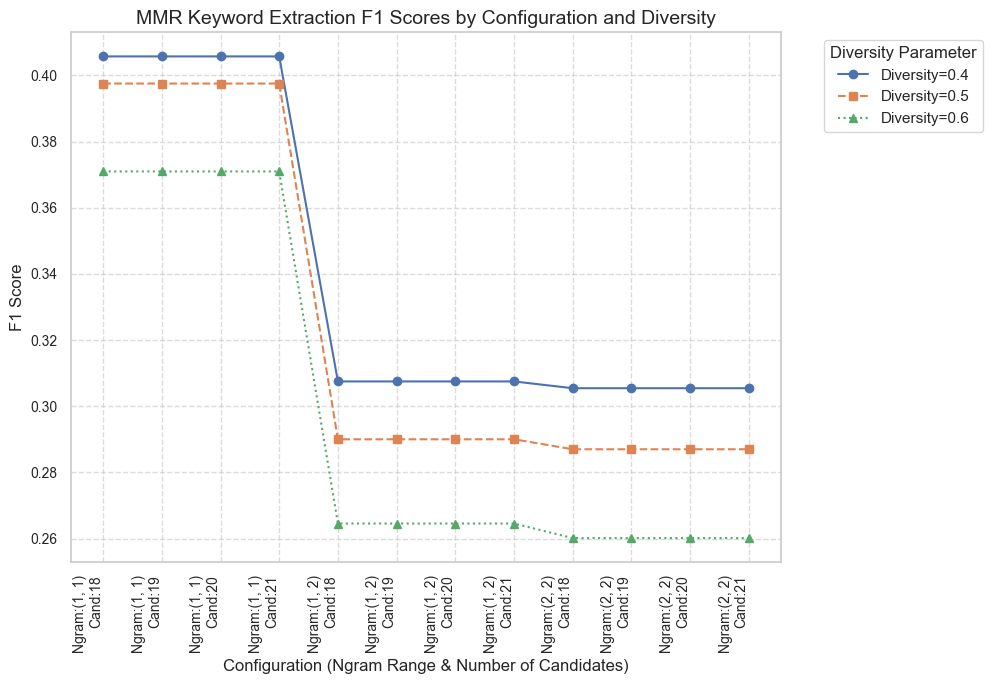

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Prepare DataFrame for summary and plotting
df = pd.DataFrame(resultsSemEval_summary_mmr) 

plt.figure(figsize=(12, 7)) 

# Define a list of markers and linestyles to cycle through
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))] # Example of custom linestyle

for i, diversity in enumerate(diversity_params):
    subset = df[(df['method'] == 'MMR') & (df['diversity'] == diversity)]
    
    # Sort for cleaner lines 
    subset = subset.sort_values(by=['ngram_range', 'nr_candidates']) 
    
    x_labels = [f"Ngram:{ng}\nCand:{nc}" for ng, nc in zip(subset['ngram_range'], subset['nr_candidates'])]
    
    plt.plot(x_labels, 
             subset['f1'], 
             marker=markers[i % len(markers)], # Cycle through markers
             linestyle=linestyles[i % len(linestyles)], # Cycle through linestyles
             label=f"Diversity={diversity}")

plt.xlabel("Configuration (Ngram Range & Number of Candidates)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("MMR Keyword Extraction F1 Scores by Configuration and Diversity", fontsize=14)
plt.legend(title="Diversity Parameter", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate and align for better visibility
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()


In [68]:
# Run MAXSUM tuning
resultsSemEval_summary_Maxsum, SemEval_best_f1_Maxsum, SemEval_best_params_Maxsum = run_experiment(docs=docs, gold_keywords=gold_keywords, use_maxsum=True)

MaxSum ngram=(1, 1) nc=18: 100%|██████████| 493/493 [01:40<00:00,  4.89it/s]


MaxSum ngram=(1, 1) nr_candidates=18 | Precision=0.769 | Recall=0.252 | F1=0.366


MaxSum ngram=(1, 1) nc=19: 100%|██████████| 493/493 [01:15<00:00,  6.50it/s]


MaxSum ngram=(1, 1) nr_candidates=19 | Precision=0.763 | Recall=0.248 | F1=0.362


MaxSum ngram=(1, 1) nc=20: 100%|██████████| 493/493 [01:31<00:00,  5.40it/s]


MaxSum ngram=(1, 1) nr_candidates=20 | Precision=0.754 | Recall=0.245 | F1=0.357


MaxSum ngram=(1, 1) nc=21: 100%|██████████| 493/493 [01:29<00:00,  5.54it/s]


MaxSum ngram=(1, 1) nr_candidates=21 | Precision=0.742 | Recall=0.240 | F1=0.351


MaxSum ngram=(1, 2) nc=18: 100%|██████████| 493/493 [01:24<00:00,  5.87it/s]


MaxSum ngram=(1, 2) nr_candidates=18 | Precision=0.604 | Recall=0.190 | F1=0.280


MaxSum ngram=(1, 2) nc=19: 100%|██████████| 493/493 [01:39<00:00,  4.94it/s]


MaxSum ngram=(1, 2) nr_candidates=19 | Precision=0.594 | Recall=0.186 | F1=0.275


MaxSum ngram=(1, 2) nc=20: 100%|██████████| 493/493 [01:51<00:00,  4.41it/s]


MaxSum ngram=(1, 2) nr_candidates=20 | Precision=0.589 | Recall=0.184 | F1=0.272


MaxSum ngram=(1, 2) nc=21: 100%|██████████| 493/493 [01:52<00:00,  4.39it/s]


MaxSum ngram=(1, 2) nr_candidates=21 | Precision=0.579 | Recall=0.180 | F1=0.266


MaxSum ngram=(2, 2) nc=18: 100%|██████████| 493/493 [01:04<00:00,  7.63it/s]


MaxSum ngram=(2, 2) nr_candidates=18 | Precision=0.568 | Recall=0.175 | F1=0.260


MaxSum ngram=(2, 2) nc=19: 100%|██████████| 493/493 [01:11<00:00,  6.93it/s]


MaxSum ngram=(2, 2) nr_candidates=19 | Precision=0.562 | Recall=0.174 | F1=0.258


MaxSum ngram=(2, 2) nc=20: 100%|██████████| 493/493 [02:06<00:00,  3.91it/s]


MaxSum ngram=(2, 2) nr_candidates=20 | Precision=0.560 | Recall=0.174 | F1=0.257


MaxSum ngram=(2, 2) nc=21: 100%|██████████| 493/493 [01:33<00:00,  5.29it/s]

MaxSum ngram=(2, 2) nr_candidates=21 | Precision=0.546 | Recall=0.171 | F1=0.252

Best: ('MaxSum', (1, 1), 18) | F1=0.366


   method ngram_range  nr_candidates diversity  precision    recall        f1
0  MaxSum      (1, 1)             18      None   0.769168  0.251770  0.366226
1  MaxSum      (1, 1)             19      None   0.763083  0.248044  0.361847
2  MaxSum      (1, 1)             20      None   0.753753  0.244608  0.357039
3  MaxSum      (1, 1)             21      None   0.742394  0.239931  0.350774
4  MaxSum      (1, 2)             18      None   0.603651  0.189752  0.279788


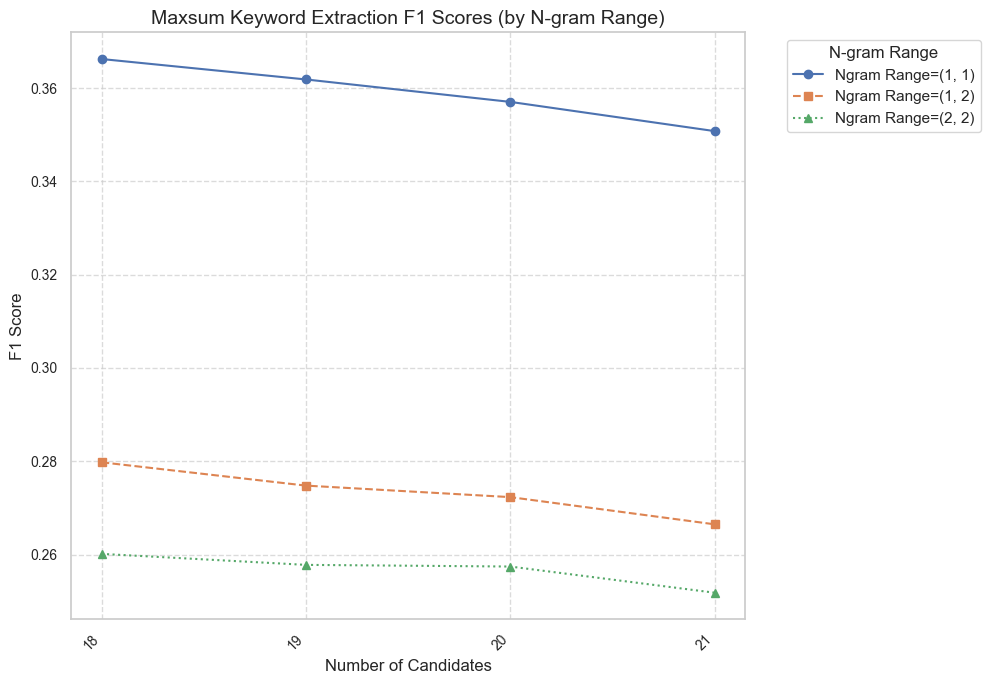

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for summary and plotting
df = pd.DataFrame(resultsSemEval_summary_Maxsum)
print(df.head())

# Filter for 'MaxSum' method
maxsum_df = df[df['method'] == 'MaxSum'].copy()

# Convert ngram_range to string for consistent x-axis labels if it's a tuple
maxsum_df['ngram_range_str'] = maxsum_df['ngram_range'].astype(str)

# Define a custom order for ngram_range for logical x-axis display
# This is crucial if (1,2) vs (1,3) vs (2,2) etc. need to be in a specific visual order.
ngram_order = sorted(maxsum_df['ngram_range_str'].unique(),
                     key=lambda x: (int(x.strip('()').split(',')[0]), int(x.strip('()').split(',')[1])))


# Define the same list of markers and linestyles to cycle through
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'P', 'X']
linestyles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))] # Example of custom linestyle


# --- Plot 1: F1 Score vs. Number of Candidates, with N-gram Range as separate lines ---
plt.figure(figsize=(12, 7)) 

# Get unique ngram_ranges to iterate and plot as separate lines
# Sort them to ensure consistent plotting order
unique_ngram_ranges = sorted(maxsum_df['ngram_range_str'].unique(),
                             key=lambda x: (int(x.strip('()').split(',')[0]), int(x.strip('()').split(',')[1])))

for i, ng_range_str in enumerate(unique_ngram_ranges):
    # Filter for the current ngram_range
    subset = maxsum_df[maxsum_df['ngram_range_str'] == ng_range_str].copy()
    
    # Sort by nr_candidates for a clean line progression
    subset = subset.sort_values(by='nr_candidates')
    
    # Check if subset is not empty to avoid plotting errors
    if not subset.empty:
        plt.plot(subset['nr_candidates'],
                 subset['f1'], # Use 'f1' directly
                 marker=markers[i % len(markers)], # Cycle through markers
                 linestyle=linestyles[i % len(linestyles)], # Cycle through linestyles
                 label=f"Ngram Range={ng_range_str}")

plt.xlabel("Number of Candidates", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Maxsum Keyword Extraction F1 Scores (by N-gram Range)", fontsize=14)
plt.legend(title="N-gram Range", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(sorted(maxsum_df['nr_candidates'].unique()), rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()